In [191]:
import numpy as np
from random import choice, random
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm import tqdm
import matplotlib.patches as mpatches
import matplotlib.animation as animation

In [192]:
class PageHinkley:
    def __init__(self, delta=0.01, threshold=300.0):
        """
        Parámetros:
          - delta: un pequeño valor (bias) que evita detectar cambios por fluctuaciones menores.
          - threshold: umbral que, al ser superado, indica que se ha detectado un cambio.
        """
        self.delta = delta
        self.threshold = threshold
        self.reset()

    def reset(self):
        """Reinicia los acumulados y contadores del test."""
        self.mean = 0.0
        self.cumulative_sum = 0.0
        self.min_cumulative_sum = 0.0
        self.n = 0

    def update(self, x):
        """
        Actualiza el PH-Test con el valor x (en este caso, la recompensa acumulada del episodio)
        y retorna True si se detecta un cambio.
        """
        self.n += 1
        # Actualización incremental de la media
        self.mean = self.mean + (x - self.mean) / self.n
        # Se acumula la diferencia entre el valor actual, la media y el delta
        self.cumulative_sum += (self.mean - x - self.delta)
        # Se guarda el mínimo acumulado
        self.min_cumulative_sum = min(self.min_cumulative_sum, self.cumulative_sum)
        # Si la diferencia acumulada (desde el mínimo) supera el umbral, se detecta un cambio
        
        #print(f"n: {self.n}, x: {x}, mean: {self.mean}, cum_sum: {self.cumulative_sum}, min_cum_sum: {self.min_cumulative_sum}")
        if (self.cumulative_sum - self.min_cumulative_sum) > self.threshold:
            return True
        else:
            return False


In [193]:
class AdaptativeAgent():
    def __init__(
        self,
        initial_state: Tuple[int, int],
        actions: list,
        n_rows: int,
        n_cols: int,
        alpha: float = 0.1,    # Tasa de aprendizaje base
        gamma: float = 0.9,    # Factor de descuento
        min_epsilon: float = 0.1,
        decay_rate: float = 0.003,
        alpha_max: float = 0.99,  # Tasa de aprendizaje máxima en caso de gran error
        td_threshold: float = 0.1,  # Umbral para activar adaptación
        k: float = 20  # Factor de pendiente para la función sigmoide
    ):
        # Parámetros de Q-learning
        self.alpha = alpha              # Tasa base
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.alpha_max = alpha_max
        self.td_threshold = td_threshold
        self.k = k
        self.effective_alpha = alpha
        
        # Configuración del entorno
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.actions = actions
        
        # Estado inicial
        self.initial_state = initial_state
        self.current_state = initial_state
        
        # Q-table (diccionario de diccionarios)
        self.q_knowledge = np.zeros((len(self.actions), self.n_rows, self.n_cols))
        # (Opcional) Puedes mantener o ampliar la memoria a corto plazo si deseas más análisis
        #self.short_term_memory = {}
        
        # Contadores
        self.steps = 0
        
        # Aux
        self.map_ix_action = {i: a for i, a in enumerate(self.actions)}  
        self.map_action_ix = {a: i for i, a in enumerate(self.actions)}      
    
    def get_next_state(self, base_state: Tuple[int, int], action: str) -> Tuple[int, int]:
        """Calcula el próximo estado según la acción"""
        row, col = base_state
        
        if action == 'Up':
            return (max(row-1, 0), col)
        if action == 'Down':
            return (min(row+1, self.n_rows-1), col)
        if action == 'Left':
            return (row, max(col-1, 0))
        if action == 'Right':
            return (row, min(col+1, self.n_cols-1))
        return base_state  # Caso por defecto
    
    def get_best_action(self, state: Tuple[int, int]) -> Tuple[str, float]:
        """Selecciona la mejor acción usando explotación"""
        action = np.argmax(self.q_knowledge[:, state[0], state[1]])
        action = self.map_ix_action[action]
        q_value = np.max(self.q_knowledge[:, state[0], state[1]])
        return action, q_value
    
    def update_q_value(
        self,
        current_state: Tuple[int, int],
        action: str,
        reward: float,
        next_state: Tuple[int, int]
    ) -> float:
        """
        Actualiza la Q-table usando una tasa de aprendizaje adaptativa que 
        fusiona el conocimiento previo con la nueva información.
        """
        action = self.map_action_ix[action]
        current_q = self.q_knowledge[action][current_state]
        # Obtener la mejor acción en el siguiente estado
        _, next_max_q = self.get_best_action(next_state)
        
        # Calcular el TD error
        td_error = reward + self.gamma * next_max_q - current_q
        
        # Función sigmoide para ajustar la tasa de aprendizaje:
        activation = 1.0 / (1.0 + np.exp(-self.k * (abs(td_error) - self.td_threshold)))
        effective_alpha = self.alpha + (self.alpha_max - self.alpha) * activation
        
        # Actualizar la Q-table de forma "fuzzy":
        self.effective_alpha = effective_alpha
        new_q = current_q + self.effective_alpha * td_error            
        
        self.q_knowledge[action][current_state] = new_q
        
        # (Opcional) Actualizar la memoria a corto plazo para el estado
        # self.short_term_memory[current_state] = self.short_term_memory[current_state][1:] + [new_q]
        
        return new_q
    
    def choose_action(self, epsilon: float) -> str:
        """Selección de acción epsilon-greedy"""
        if random() < epsilon:
            # Exploración: filtrar solo acciones que cambien el estado
            valid_actions = [
                a for a in self.actions
                if self.get_next_state(self.current_state, a) != self.current_state
            ]
            if valid_actions:
                return choice(valid_actions)
            else:
                return choice(self.actions)
        # Explotación
        best_action, _ = self.get_best_action(self.current_state)
        return best_action
    
    def epsilon_decay(self, step: int) -> float:
        """Decaimiento exponencial de epsilon"""
        return self.min_epsilon + (1 - self.min_epsilon) * np.exp(-self.decay_rate * step)
    
    def move(self, reward: float, action: str) -> float:
        """
        Realiza un paso completo de Q-learning:
          1. Actualiza la Q-table usando la tasa de aprendizaje adaptativa.
          2. Cambia al nuevo estado.
        """
        next_state = self.get_next_state(self.current_state, action)
        
        new_q = self.update_q_value(
            current_state=self.current_state,
            action=action,
            reward=reward,
            next_state=next_state
        )
        
        # Actualizar el estado y el contador de pasos
        self.current_state = next_state
        self.steps += 1
                
        return new_q
    
    def restart(self) -> None:
        """Reinicia el agente a su estado inicial sin borrar la Q-table (se conserva el conocimiento)"""
        self.current_state = self.initial_state
        self.steps = 0
        
    def __str__(self) -> str:
        return f"AdaptativeAgent at {self.current_state} with Q-values {self.q_knowledge[self.current_state]}"


93.0
Cambio detectado en episodio 103 con recompensa -30.0
Cambio detectado en episodio 104 con recompensa -37.0
Cambio detectado en episodio 105 con recompensa -37.0
Cambio detectado en episodio 106 con recompensa -37.0
Cambio detectado en episodio 107 con recompensa -37.0
Cambio detectado en episodio 108 con recompensa -37.0
Cambio detectado en episodio 109 con recompensa -37.0
Cambio detectado en episodio 110 con recompensa -37.0
Cambio detectado en episodio 111 con recompensa -37.0
Cambio detectado en episodio 112 con recompensa -37.0
Cambio detectado en episodio 113 con recompensa -37.0
Cambio detectado en episodio 114 con recompensa -37.0
Cambio detectado en episodio 115 con recompensa -37.0
Cambio detectado en episodio 116 con recompensa -37.0
Cambio detectado en episodio 117 con recompensa -37.0
Cambio detectado en episodio 118 con recompensa 87.0
Cambio detectado en episodio 119 con recompensa -37.0
Cambio detectado en episodio 120 con recompensa -37.0
Cambio detectado en epis

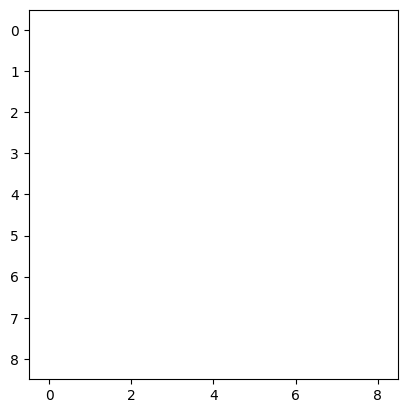

In [194]:
# Inicialización del entorno y parámetros
N_ROWS = 9
N_COLS = 9
GRID_WORLD = np.zeros((N_ROWS, N_COLS)) - 1

# Definición de los estados meta
GOAL_STATE_1 = (0, 0)
GOAL_STATE_2 = (8, 8)
GRID_WORLD[GOAL_STATE_1] = 100  # Objetivo inicial
GRID_WORLD[GOAL_STATE_2] = -1

EXPLOTATION = 0.2


# Inicialización del agente
agent = AdaptativeAgent(
    initial_state=(4, 4),
    actions=['Up', 'Down', 'Left', 'Right'],
    n_rows=N_ROWS,
    n_cols=N_COLS,
    decay_rate=0.002,
    alpha=0.1,
    alpha_max=0.99,
    td_threshold=0.1,
    k=20
)

# Inicialización del Page-Hinkley Test
ph_test = PageHinkley(delta=0.5, threshold=120.0)

# Variables para el seguimiento del entrenamiento
learning_curve = []
exploration_curve = []
step_changes = []
alpha_evol = []
episode = 0
ite = 0  # Contador total de iteraciones
e = 0     # Contador para la función de decaimiento de epsilon

# Variable para la recompensa acumulada del episodio
episode_reward = 0.0

# Para este ejemplo, modificaremos el entorno en episodios específicos
episode_changes = [100, 300, 550, 750, 950]

ims = []
fig, ax = plt.subplots()

detected_changes = 0

# Bucle de entrenamiento
while episode < 1100:
    # Selecciona la acción usando epsilon adaptativo
    adaptive_epsilon = agent.epsilon_decay(step=e)
    action = agent.choose_action(adaptive_epsilon)
    
    initial_state = agent.current_state
    next_state = agent.get_next_state(initial_state, action)
    reward = GRID_WORLD[next_state]
    
    # Acumula la recompensa del episodio
    episode_reward += reward

    # Realiza el movimiento y actualiza la Q-table
    new_q = agent.move(reward, action)
    
    # Actualiza métricas (por ejemplo, para visualización)
    exploration_curve.append([adaptive_epsilon, new_q])
    alpha_evol.append(agent.effective_alpha)
    
    ite += 1
    # Actualización del contador para el decaimiento de epsilon según ciertas condiciones
    if (episode < 100) or (150 < episode < 300) or (350 < episode < 550) or (600 < episode < 750) or (800 < episode < 950) or (episode > 1000):
        e += 1
    else:
        e += 0

    # Finaliza el episodio si se alcanza un objetivo o se excede un límite de pasos
    if (next_state in [GOAL_STATE_1, GOAL_STATE_2]) or (agent.steps > (N_COLS + N_ROWS) * 2):
        episode += 1
        
        # Registra la recompensa media del episodio (puedes ajustar la métrica que prefieras)
        learning_curve.append(episode_reward)
        
        if ph_test.update(episode_reward):
            print(f"Cambio detectado en episodio {episode} con recompensa {episode_reward}")
            e = 1
            detected_changes += 1
            if detected_changes > 50:
                ph_test.reset()
            
        
        
        # (Opcional) Si en episodios específicos se desea cambiar el entorno:
        if episode in episode_changes:
            #e = 0
            # Alterna el objetivo cambiando la recompensa en el grid
            if episode % 150 != 0:
                print(episode_reward)
                GRID_WORLD[GOAL_STATE_1] = -1
                GRID_WORLD[GOAL_STATE_2] = 100
            else:
                GRID_WORLD[GOAL_STATE_1] = 100
                GRID_WORLD[GOAL_STATE_2] = -1
            step_changes.append(ite)
            
        
        # Reinicia el agente y la recompensa acumulada para el siguiente episodio
        agent.restart()
        episode_reward = 0.0
        
    # (Opcional) Visualización periódica de la Q-table
    if ite % 100 == 0:
        im = ax.imshow(np.max(agent.q_knowledge, axis=0), animated=True)
        color_goal_1 = 'green' if GRID_WORLD[GOAL_STATE_1] == 100 else 'red'
        color_goal_2 = 'red' if color_goal_1 == 'green' else 'green'
        scatter_goal_1 = ax.scatter(GOAL_STATE_1[1], GOAL_STATE_1[0], color=color_goal_1, s=100, animated=True)
        scatter_goal_2 = ax.scatter(GOAL_STATE_2[1], GOAL_STATE_2[0], color=color_goal_2, s=100, animated=True)
        ims.append([im, scatter_goal_1, scatter_goal_2])
        
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
            
print("Entrenamiento finalizado.")

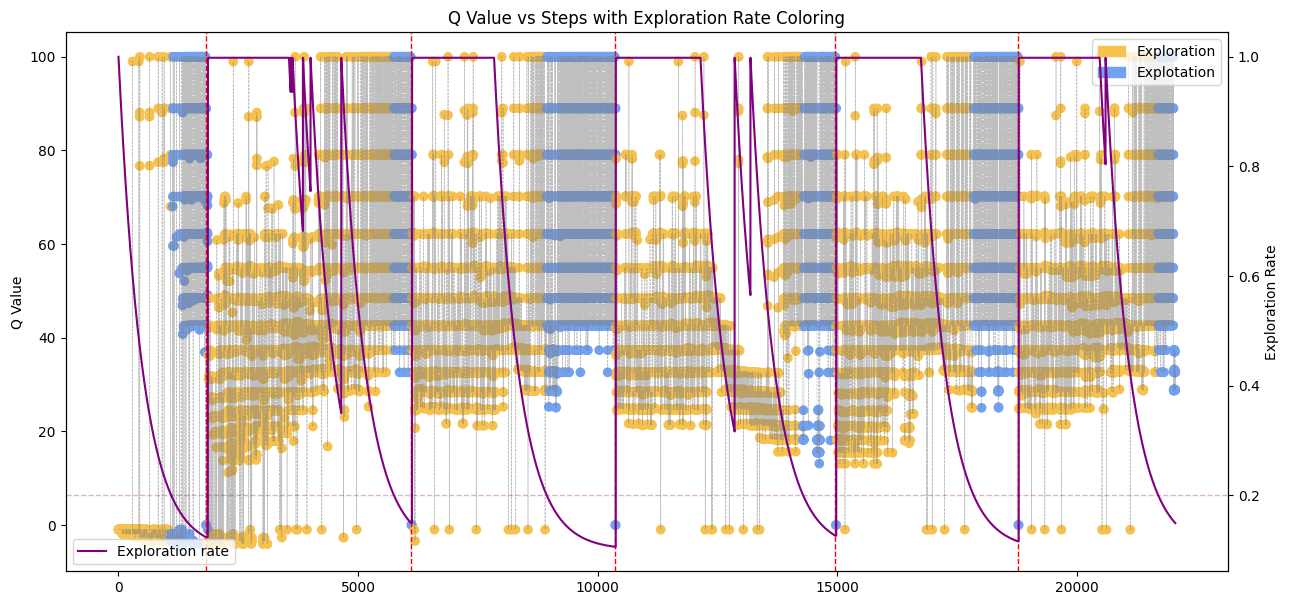

In [195]:
eps, q_val = list(zip(*exploration_curve))

plt.figure(figsize=(15, 7))
plt.plot(q_val, c='gray', alpha=0.5, linestyle='--', linewidth=.5)
plt.scatter(range(len(q_val)), q_val, c=['#71a1f0'if e < EXPLOTATION else '#f7c14d'for e in eps])
plt.ylabel('Q Value')

blue_patch = mpatches.Patch(color='#71a1f0', label='Explotation',)
orange_patch = mpatches.Patch(color='#f7c14d', label='Exploration')
plt.legend(handles=[orange_patch, blue_patch], loc='upper right', fontsize=10)

for change in step_changes:
    plt.axvline(x=change, color='red', linestyle='--', linewidth=1)

# add another axis
plt.twinx()
plt.plot(eps, label=f'Exploration rate', c='purple')
plt.axhline(EXPLOTATION, color='purple', linestyle='--', alpha=0.3, linewidth=1)
plt.ylabel('Exploration Rate')
plt.legend(loc='lower left')
plt.xlabel('Steps')

plt.title('Q Value vs Steps with Exploration Rate Coloring')

plt.show()

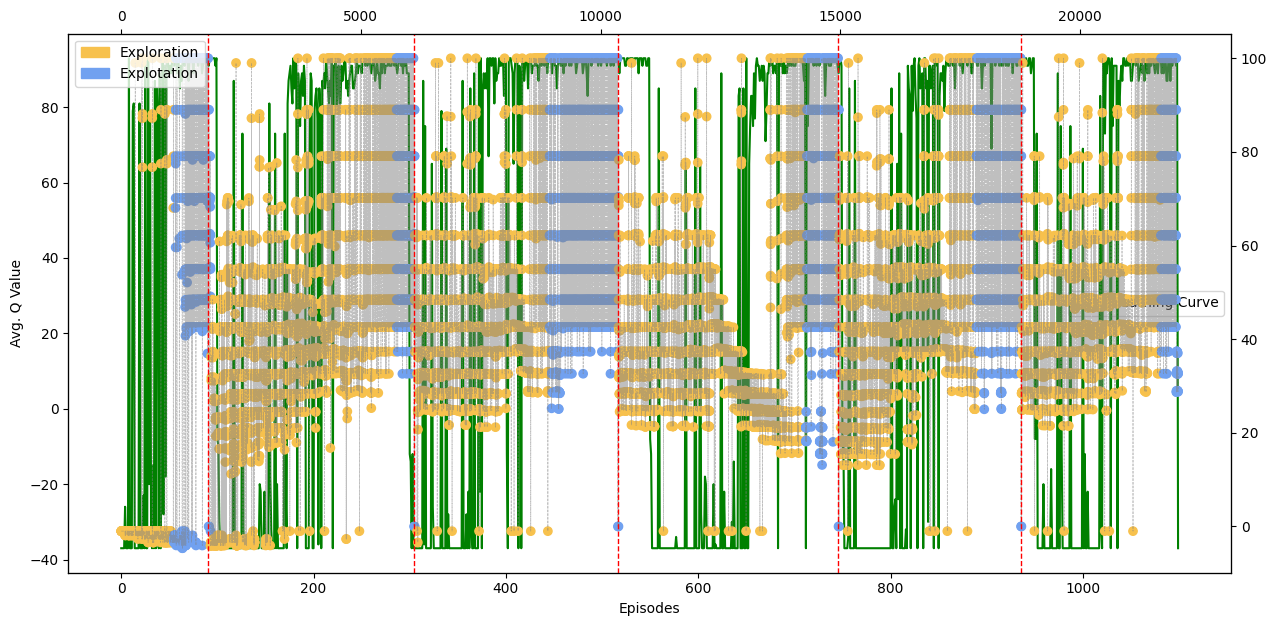

In [196]:
plt.figure(figsize=(15, 7))

plt.plot(learning_curve, c='green', zorder=1000, label='Learning Curve')
plt.ylabel('Avg. Q Value')
plt.xlabel('Episodes')
plt.legend()

    
plt.twinx()
plt.twiny()
plt.plot(q_val, c='gray', alpha=0.5, linestyle='--', linewidth=.5)
plt.scatter(range(len(q_val)), q_val, c=['#71a1f0'if e < EXPLOTATION else '#f7c14d'for e in eps])
plt.ylabel('Q Value')
for change in step_changes:
    plt.axvline(x=change, color='red', linestyle='--', linewidth=1)

blue_patch = mpatches.Patch(color='#71a1f0', label='Explotation',)
orange_patch = mpatches.Patch(color='#f7c14d', label='Exploration')
plt.legend(handles=[orange_patch, blue_patch], loc='upper left', fontsize=10)


plt.show()

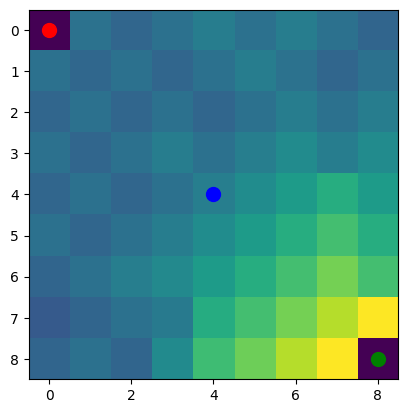

In [197]:
plt.imshow(np.max(agent.q_knowledge, axis=0))
plt.scatter(*GOAL_STATE_1[::-1], c='red', s=100, label='Goal 1')
plt.scatter(*GOAL_STATE_2[::-1], c='green', s=100, label='Goal 2')
plt.scatter(*agent.initial_state[::-1], c='blue', s=100, label='Start')

In [198]:
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

In [199]:
ani.save("../simulations/memory_stm_v3.mp4")